## Demonstrate model variance for a simple predictive machine learning method with Bootstrap of the training dataset
#### Ahmed Aboahmed
#### Petroleum and Geosystems Engineering, Cockrell School of Engineering
### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences

_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Ademide Mabadeje, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/ademidemabadeje/)


## Excutive summary

Model variance refers to the variability or instability of a predictive model's performance when trained on different subsets of the training data. Bootstrap resampling is a technique used to estimate model variance by repeatedly sampling subsets (with replacement) from the training dataset and training the model on each subset. This allows us to observe how the model's performance varies with different training subsets.

### Considerations:
* #### Variance / Bias trade-off:

Model variance is often considered along with bias. A model with high variance may overfit the training data (capturing noise), while a model with high bias may oversimplify and miss important patterns (underfit).
* #### Hyperparameter Tuning:

Hyperparameter tuning may help to identify the set of hyperparameters that result in models with lower variance considering variance / bias trade-off.

In [1]:
import numpy as np                                          
import scipy.stats as st                                    
import pandas as pd                                         
import matplotlib.pyplot as plt                             
from sklearn.metrics import mean_squared_error, r2_score    
from pandas import read_csv
from sklearn.model_selection import train_test_split
from mlxtend.evaluate import bias_variance_decomp
from sklearn.preprocessing import StandardScaler            
from sklearn import metrics                                
import geostatspy.GSLIB as GSLIB         
import geostatspy.geostats as geostats    
import pandas as pd                      
import seaborn as sns                     
from scipy import stats                   
import math                               
import scipy.signal as signal             
import random
import seaborn as sns                     
from sklearn.linear_model import Lasso                      
import warnings
warnings.filterwarnings('ignore')                        

# Loading the Data

The dataset used in this workflow is taken from the GitHub page of Prof. Michael Pyrcz. It can be found in the link: [Data from GeostatsGuy](https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV_v4.csv)

We will use two features only in this workflow.

* **Porosity** - The ratio of the pore volume to the ratio of the bulk volume of a porous medium. 
* **Permeability** - The ability of porous media to transmit fluids.

In [2]:
#load data
df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV_v4.csv')                                                   # preview the DataFrame
df = df.drop(df.columns[0], axis=1)
df = df.drop(df.columns[3:], axis=1)
df = df.drop(df.columns[-1], axis=1)
df.head()

,Por,Perm
0,12.08,2.92
1,12.38,3.53
2,14.02,2.59
3,17.67,6.75
4,17.52,4.57


## Workflow milestones


####  Step 1 - Split data into training and testing data sets with visualization  <br>
* 80% of the data was used for training and the rest for testing to make sure the model has enough data proportion for both training and model evaluation.
####  Step 2 - Utilize Lasso regression as our predictive machine learning method  <br>
* In sensitive to outliers.
* Utilization of L1 norm which is more robust than L2 norm.
* Introduce Lambda hyper parameter which utilizes variance bias trade off.
####  Step 3 - Bootstrap over training data set to produce more realizations  <br>
* Randomly sample (with replacement) from the original training dataset to create multiple bootstrap samples.
* Each bootstrap sample is of the same size as the original dataset but may contain duplicate instances and omit some instances.
####  Step 4 - Lasso regression over Bootstrap realizations over different values of Lambda  <br>
* Apply Lasso regression over Bootstrap realizations over different values of Lambda using nested loops.

## References:
This workflow uses the implementation and illustration of Lasso Regression and Bootstrap, from the notebooks "SubsurfaceDataAnalytics_Lasso.ipynb" and "SubsurfaceDataAnalytics_bootstrap.ipynb". 

Workflows can be found here: 
* [GeostatsGuy Lasso](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Lasso.ipynb)
* [GeostatsGuy Bootstrap](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_bootstrap.ipynb)

### Step 1. Split data into training and testing data sets with visualization


In [3]:
df_train = df.iloc[0:160,:]                                  
df_test = df.iloc[160:]                                      
df.describe().transpose()           

,count,mean,std,min,25%,50%,75%,max
Por,200.0,14.99115,2.971176,6.55,12.9125,15.070,17.4025,23.55
Perm,200.0,4.33075,1.731014,1.13,3.1225,4.035,5.2875,9.87


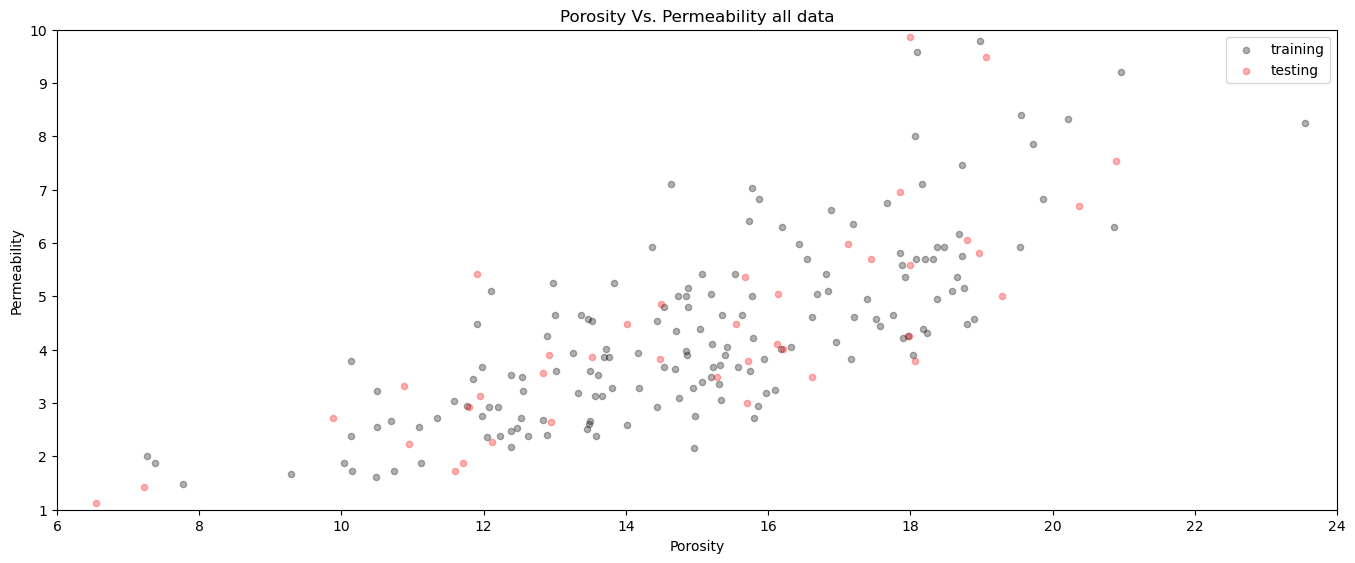

In [4]:
por_train = df_train['Por'].values                                   
perm_train = df_train['Perm'].values                       
por_test = df_test['Por'].values                       
perm_test = df_test['Perm'].values                        
n_train = len(df_train)
n_test = len(df_test)
plt.scatter(df_train["Por"].values, df_train["Perm"],  color='black', s = 20, alpha = 0.3, label = 'training')
plt.scatter(df_test["Por"].values, df_test["Perm"],  color='red', s = 20, alpha = 0.3, label = 'testing')
plt.title('Porosity Vs. Permeability all data'); plt.xlabel('Porosity'); plt.ylabel('Permeability')
plt.legend()
plt.xlim(6,24); plt.ylim(1,10)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.show()

* Testing data has a good portion of the entire data set (20%) which enhances model evaluation.

### Step 2. Utilize Lasso regression as our predictive machine learning method
*   Training the model over training data set with a preset hyperparameter Lambda and check the quality of fit with the training data.

Coefficients:  0.431, Intercept:  -2.149


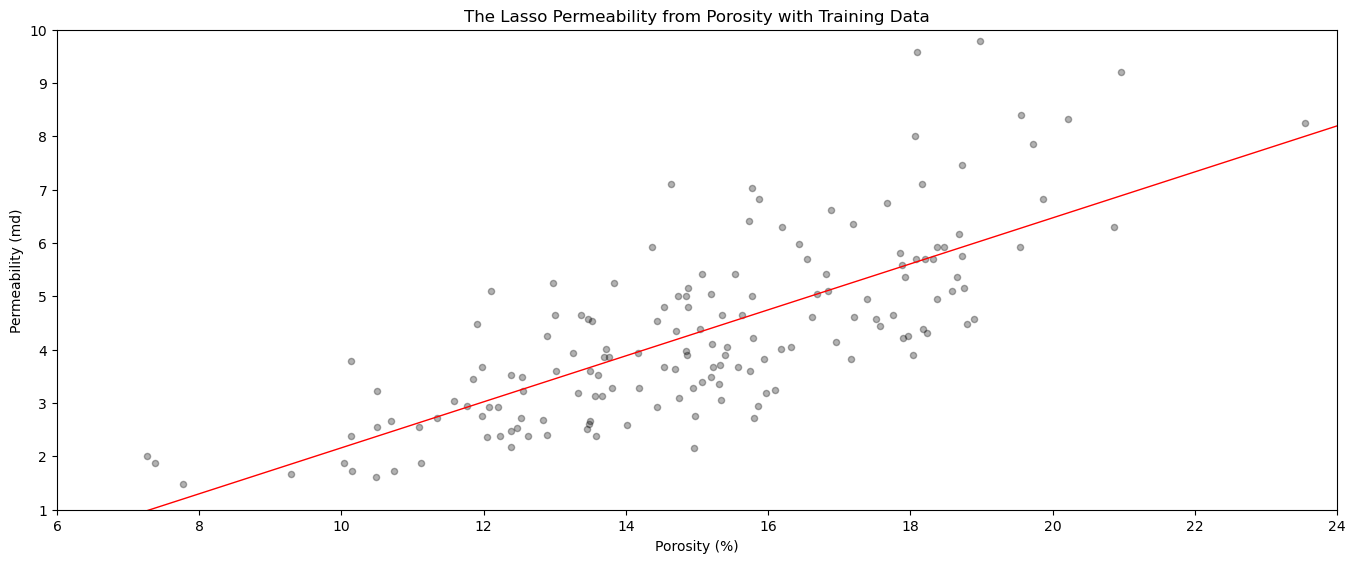

In [5]:
lam = 0.10

# Step 1. Instantiate the Model 
lasso_reg = Lasso(alpha=lam)

# Step 2: Fit the Data on Training Data
lasso_reg.fit(df_train["Por"].values.reshape(n_train,1), df_train["Perm"]) # fit model
Porosity_model = np.linspace(6,24,10)

# Print the model parameters
Permeability_lasso_model = lasso_reg.predict(Porosity_model.reshape(10,1)) # predict with the fit model
print('Coefficients: ', str(round(lasso_reg.coef_[0],3)) + ', Intercept: ', str(round(lasso_reg.intercept_,3))) 

# Plot model fit
plt.subplot(111)
plt.scatter(df_train["Por"].values, df_train["Perm"],  color='black', s = 20, alpha = 0.3)
plt.plot(Porosity_model,Permeability_lasso_model, color='red', linewidth=1)
plt.title('The Lasso Permeability from Porosity with Training Data'); plt.xlabel('Porosity (%)'); plt.ylabel('Permeability (md)')
plt.xlim(6,24); plt.ylim(1,10)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.show()

We can notice the model performs well within the training data set. However, the true evaluation should consider the ability of the model to predict outside the training data set. So, model evaluation over testing data set is performed next.

*  Make predictions with the trained model and test the quality of fit over testing data.

Variance explained: 0.60
Residual: mean = -0.09, standard deviation = 1.5


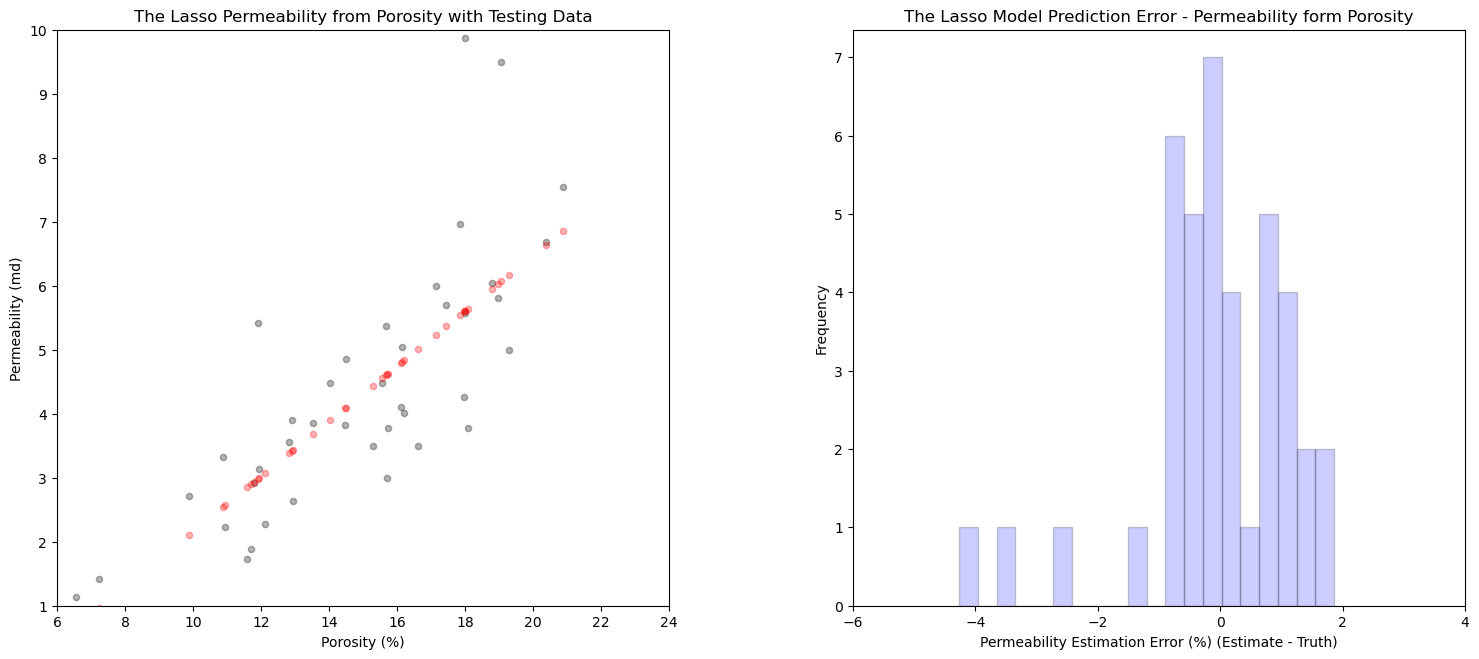

In [6]:
# Step 3: - Make predictions using the testing dataset
y_pred = lasso_reg.predict(df_test['Por'].values.reshape(n_test,1))

# Report the goodness of fit
print('Variance explained: %.2f' % r2_score(df_test['Perm'].values, y_pred))

# Plot testing diagnostics 
plt.subplot(121)
plt.scatter(df_test['Por'].values, df_test['Perm'].values,  color='black', s = 20, alpha = 0.3)
plt.scatter(df_test['Por'], y_pred, color='red', s = 20, alpha = 0.3)
plt.title('The Lasso Permeability from Porosity with Testing Data'); plt.xlabel('Porosity (%)'); plt.ylabel('Permeability (md)')
plt.xlim(6,24); plt.ylim(1,10)

y_res = y_pred - df_test['Perm'].values

print('Residual: mean = ' + str(round(np.average(y_res),2)) + ', standard deviation = ' + str(round(np.var(y_res),2)))

plt.subplot(122)
plt.hist(y_res, alpha = 0.2, color = 'blue', edgecolor = 'black', bins=20)
plt.title('The Lasso Model Prediction Error - Permeability form Porosity'); plt.xlabel('Permeability Estimation Error (%) (Estimate - Truth)'); plt.ylabel('Frequency')
plt.xlim(-6,4)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

* We can notice the robustness and stability of our model over testing data and the insensitivity to outliers using Lasso Regression. 
* This process helps assess how well the model generalizes to new, unseen examples. 

### Step 3. Bootstrap over training data set to produce more realizations
* Bootstrapping is repeatedly resampling with replacement from the training data. 
* The main idea is to create multiple datasets (bootstrap samples) by drawing random samples from the training data, allowing  to assess the variability of an estimate.


In [7]:
# Bootstrap realizations of the original training data set
real=200                                                   
nsample=160                                                
samples=[]            
for l in range(0, real):                                   
    boot= df_train.sample(n = nsample, replace=True)    
    samples.append(boot)

boot_df = pd.DataFrame(np.array(samples). reshape(160,400))  
boot_df.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,17.17,3.82,13.50,2.66,16.19,6.30,12.52,2.72,15.73,6.42,...,14.84,3.97,18.90,4.57,13.37,4.66,14.37,5.93,18.21,5.70
1,18.72,5.75,17.21,4.62,18.32,5.70,16.95,4.14,16.10,3.25,...,14.88,4.81,15.19,5.05,14.88,5.16,13.01,3.60,17.92,5.37
2,18.59,5.10,10.50,3.22,17.21,4.62,18.75,5.16,13.48,2.61,...,14.73,5.00,14.69,3.63,10.15,1.72,17.21,4.62,14.44,4.53
3,10.14,3.78,15.75,3.60,16.32,4.06,10.50,3.22,16.55,5.70,...,18.04,3.90,11.91,4.48,13.61,3.53,18.18,4.39,14.73,5.00
4,18.66,5.37,15.78,5.00,13.00,4.66,15.94,3.82,17.89,4.22,...,10.13,2.39,14.44,4.53,15.40,3.90,12.54,3.49,12.47,2.53


* This table resembles the 200 realizations of our original training data set using bootstrap technique.
* Each two successive columns represent a new realization of Porosity and Permeability respectively.

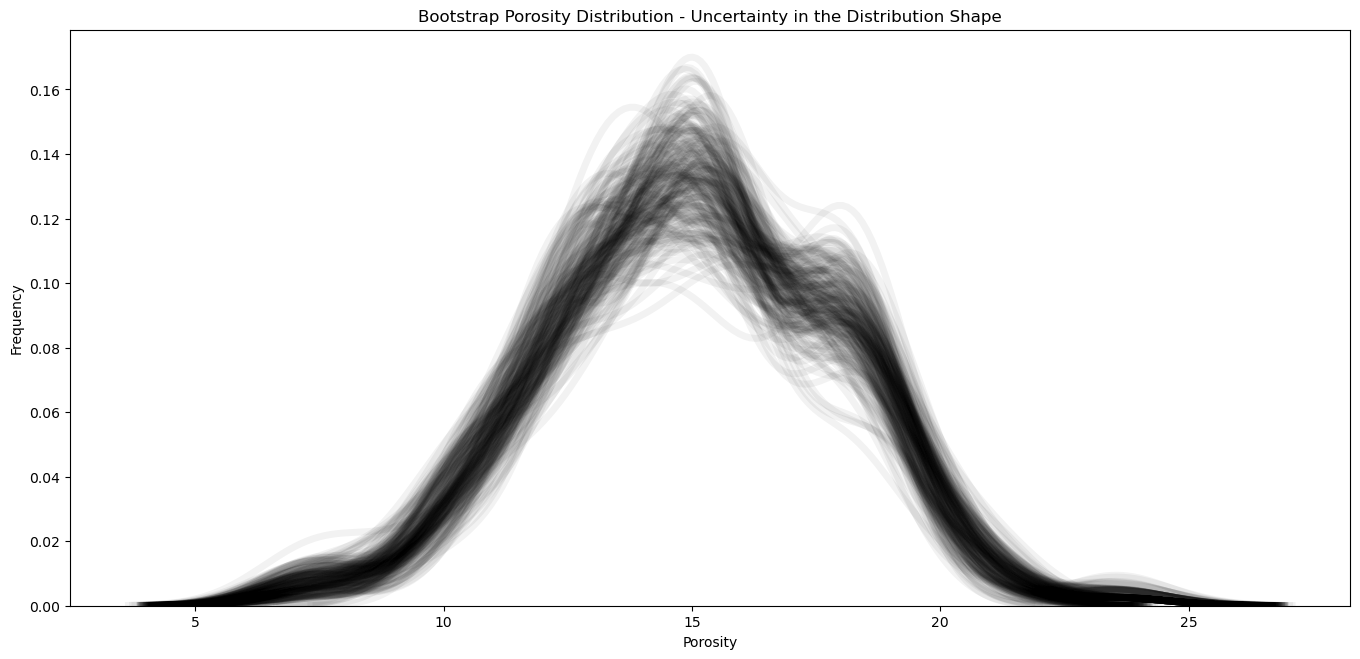

In [8]:
for ireal in range(0,400,2):              
    sns.kdeplot(boot_df[ireal], color = 'black',alpha=0.05,lw=5)
plt.title('Bootstrap Porosity Distribution - Uncertainty in the Distribution Shape')
plt.xlabel('Porosity')
plt.ylabel('Frequency')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

* Bootstrap realizations over porosity is demonstrated.

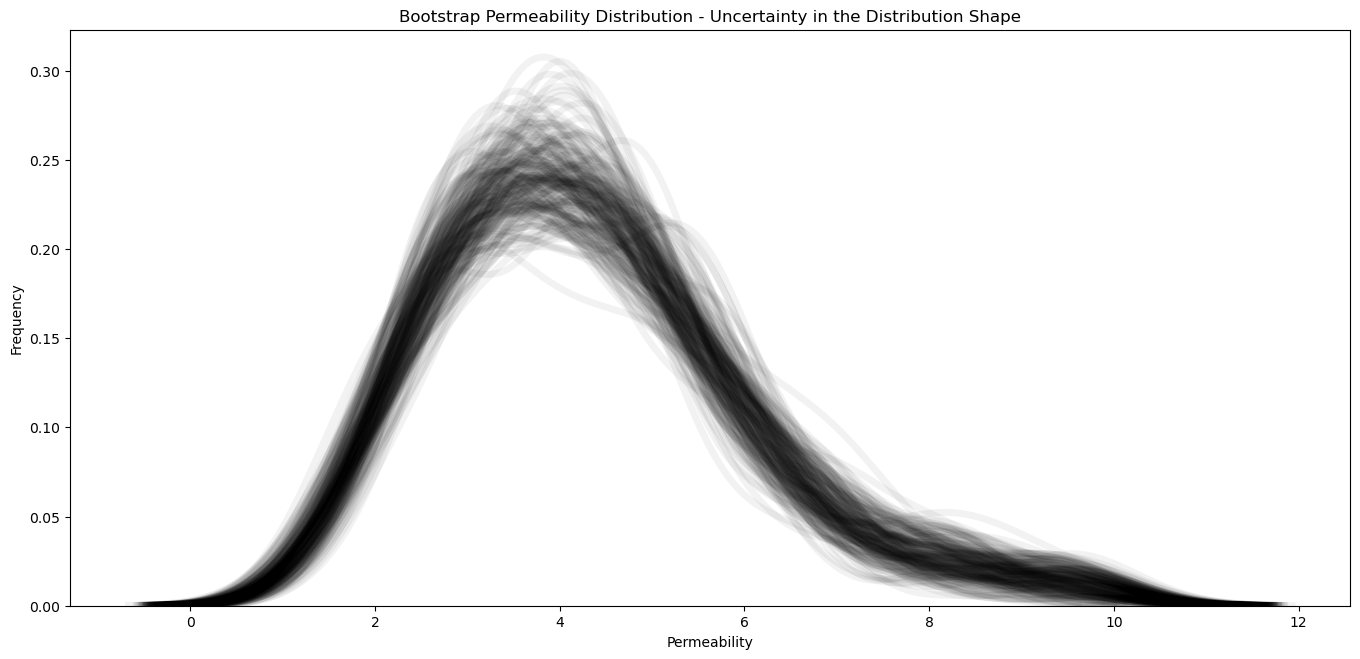

In [9]:
for ireal in range(1,400,2):              
    sns.kdeplot(boot_df[ireal], color = 'black',alpha=0.05,lw=5)
plt.title('Bootstrap Permeability Distribution - Uncertainty in the Distribution Shape')
plt.xlabel('Permeability')
plt.ylabel('Frequency')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

* Bootstrap realizations over Permeability is demonstrated.

### Step 4. Lasso regression over Bootstrap realizations over different values of Lambda
### Model Variance:
* Definition: Model variance refers to the amount by which the predicted values of the model would change if we estimated it using a different training dataset. So, it represents the sensitivity to dataset.
* Impact: High variance can lead to overfitting, where the model captures noise in the training data and performs poorly on new, testing data.
### Model Bias:
* Definition: Model bias is the error introduced by approximating a real-world problem, which may be extremely complex, by a much simpler model.
* Impact: High bias can lead to underfitting, where the model is too simple to capture the underlying patterns in the data.
### Irreducible error:
* Definition: Irreducible error is the inherent variability in a system that cannot be reduced by any model. It is the error that remains even with the best possible model.
* Impact: This error represents the noise or randomness in the data that cannot be eliminated.
### Test Mean Squared Error (MSE):
* Definition: Testing MSE can be represented by the summation of the previously stated errors.
* MSE=Variance+Bias+Irreducible Error.

In [10]:
real = 200                                                     
nsamples = 160                                               
nlam = 100                                              
variance=np.zeros(real)                                       
bias=np.zeros(real)                                     
irreducible=np.zeros(real)
y_var=np.zeros(nlam)
y_bias= np.zeros(nlam)
y_irreducible=np.zeros(nlam)
lambd = np.linspace(0,5,nlam)          
for ilam in range(0,len(lambd)):                                           
    for l in range(0, real):                                   
        df_sample = df_train.sample(n = nsamples, replace=True)                 
        lasso_reg = Lasso(alpha=lambd[ilam])             
        lasso_reg.fit(df_sample["Por"].values.reshape(nsamples,1), df_sample["Perm"]) 
        lasso_predict = lasso_reg.predict(por_test.reshape(n_test,1))
        irreducible[l]=np.var(perm_test)
        variance[l]=np.var(lasso_predict)
        bias[l]=np.mean((perm_test-lasso_predict)**2)
    y_var[ilam] = np.mean(variance)                     
    y_bias[ilam]=np.mean(bias)                    
    y_irreducible[ilam]=np.mean(irreducible)
Error=y_var+y_bias+y_irreducible                                 

### Relationships:
* Lasso regression adds a penalty term based on the absolute values of the coefficients. The regularization term is proportional to the sum of the absolute values of the coefficients multiplied by a tuning parameter (lambda).
* Bias-Variance Trade-off: There is a trade-off between bias and variance. Increasing model complexity typically reduces bias but increases variance and vice versa.
* For better interpretation we will visualize all errors simultaneously.

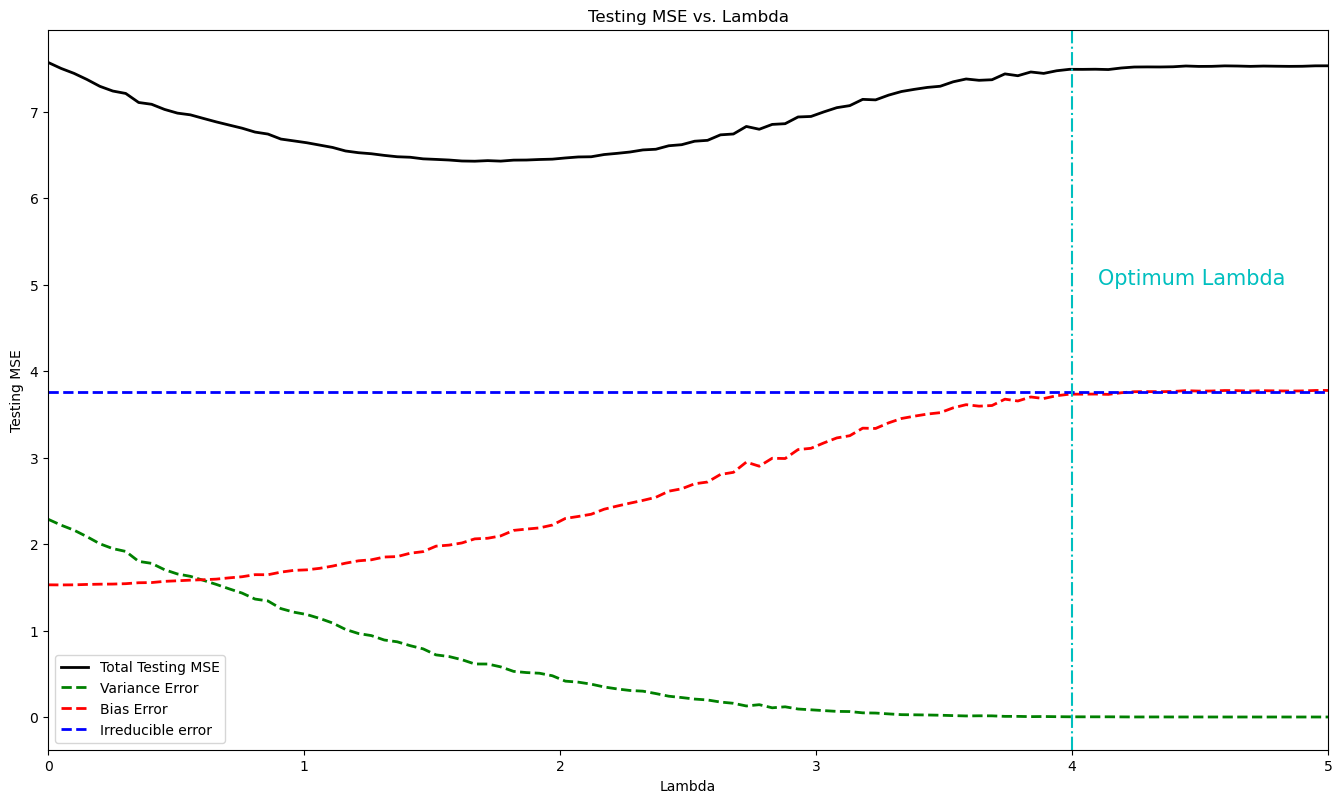

In [11]:
plt.plot(lambd, Error,  color='black', linewidth = 2, label = 'Total Testing MSE')
plt.plot(lambd, y_var,  color='g', linewidth = 2, label = 'Variance Error',linestyle='dashed')
plt.plot(lambd, y_bias,  color='r', linewidth = 2, label = 'Bias Error',linestyle='dashed')
plt.plot(lambd, y_irreducible,  color='b', linewidth = 2, label = 'Irreducible error',linestyle='dashed')
plt.axvline(x=4, color='c', linestyle='dashdot')               
plt.xlim(0,5)
plt.text(4.1, 5, 'Optimum Lambda',fontsize = 15,color = 'c')
plt.title('Testing MSE vs. Lambda'); 
plt.xlabel('Lambda'); 
plt.ylabel('Testing MSE')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.5, wspace=0.2, hspace=0.2)
plt.legend()
plt.legend(loc='lower left')

### Results 
* When λ is set to zero, the L1 regularization term has no effect, and the loss function reduces to the standard linear regression loss function.
* Now, as we tune the regularization hyperparameter λ, we are controlling the trade-off between fitting the data well (Bias) and keeping the model more stable (Variance). 
* At the optimal value of λ, the Lasso objective function is minimized. This function includes both Mean Squared Error (MSE) and L1 Regularization Term.
* This demonstration assures the concept of Bias-Variance Trade-off. This implies that in order to increase model stability and reduce model variance, we have to accept an increase in the model bias.
* This trade-off will reduce model overfit and improve model generalization.


I hope this was helpful,
### Ahmed Aboahmed
PHD student at Hildebrand Department of Petroleum and Geosystems Engineering, University of Texas at Austin <br>
GRA at Center for Subsurface Energy and the Environment (CSEE), Cockrell School of Engineering

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
